**DATA PREPARATION**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os

dataset_path = "/content/drive/MyDrive/OsteoporosisDetectionModelDataset/dataset"
print(os.listdir(dataset_path))

['.DS_Store', 'normal', 'osteoporosis']


In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Image Size
IMG_SIZE = (224, 224)


Loading Images

In [9]:
def load_images_from_folder(folder):
    images = []
    labels = []  # Assuming subfolders are class labels
    for class_label in os.listdir(folder):
        class_path = os.path.join(folder, class_label)
        if os.path.isdir(class_path):  # Ensure it's a directory
            for filename in os.listdir(class_path):
                img_path = os.path.join(class_path, filename)
                image = load_img(img_path, target_size=IMG_SIZE, color_mode="rgb")
                image = img_to_array(image) / 255.0  # Normalize
                images.append(image)
                labels.append(class_label)
    return np.array(images), np.array(labels)

# Load dataset
X, y = load_images_from_folder(dataset_path)
print(f"Loaded {len(X)} images with labels {set(y)}")
# The images are resized, converted to arrays, and normalized.


Loaded 2079 images with labels {np.str_('normal'), np.str_('osteoporosis')}


Data Augumentation

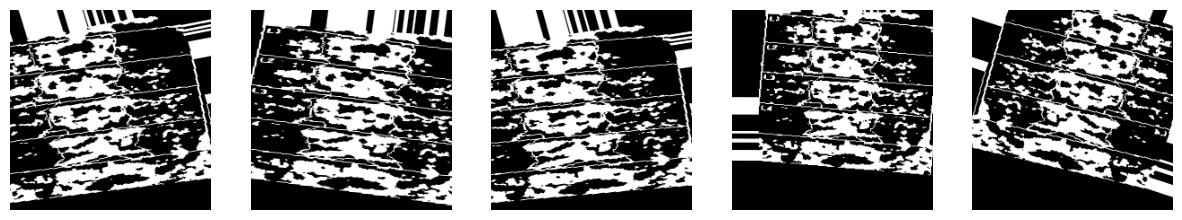

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Example: Augment one image
sample_image = X[0].reshape((1, *IMG_SIZE, 3))  # Reshape for augmentation
aug_iter = datagen.flow(sample_image)

# Show augmented images
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    aug_img = next(aug_iter)[0]
    axes[i].imshow(aug_img)
    axes[i].axis("off")
plt.show()
#create variations of the image improves accuracy


**Feature Extraction**

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import gabor

# Apply Gabor Filters to extract texture and pattern
def gabor_features(image, frequencies=[0.1, 0.3, 0.5]):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
    features = []

    for theta in range(4):  # 4 orientations
        theta = theta / 4. * np.pi
        for freq in frequencies:
            filt_real, _ = gabor(gray, frequency=freq, theta=theta)
            features.append(filt_real.mean())  # Mean as feature
            features.append(filt_real.var())  # Variance as feature
    return np.array(features)

# Extract Gabor features for all images
gabor_features_list = np.array([gabor_features(img) for img in X])
print(f"Gabor Features Shape: {gabor_features_list.shape}")


Gabor Features Shape: (2079, 24)


Local Binary Patterns (LBP)

In [ ]:
from skimage.feature import local_binary_pattern

# Apply LBP local binary pattern extract local texture features,
# providing information about patterns in small image regions.

def lbp_features(image, radius=3, points=8):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    lbp = local_binary_pattern(gray, points, radius, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, points + 3), range=(0, points + 2))
    hist = hist.astype("float")
    hist /= hist.sum()  # Normalize
    return hist

# Extract LBP features
lbp_features_list = np.array([lbp_features(img) for img in X])
print(f"LBP Features Shape: {lbp_features_list.shape}")


/usr/local/lib/python3.11/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


LBP Features Shape: (2079, 10)


Resnet 50 - extract deep learning features

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model

# Load Pretrained ResNet50 Model
base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)

# Extract deep learning features
def extract_resnet_features(image_array):
    image_array = preprocess_input(image_array)  # Preprocess for ResNet50
    return feature_extractor.predict(image_array)

# Apply feature extraction
resnet_features_list = np.array([extract_resnet_features(img.reshape(1, *IMG_SIZE, 3)).flatten() for img in X])
print(f"ResNet50 Features Shape: {resnet_features_list.shape}")


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━

Feature Scaling -  brings to a similar range

Feature Concatenation -single feature vector


In [ ]:
from sklearn.preprocessing import StandardScaler

# Normalize Features
scaler = StandardScaler()
gabor_features_scaled = scaler.fit_transform(gabor_features_list)
lbp_features_scaled = scaler.fit_transform(lbp_features_list)
resnet_features_scaled = scaler.fit_transform(resnet_features_list)

# Concatenate Features
final_features = np.hstack([gabor_features_scaled, lbp_features_scaled, resnet_features_scaled])
print(f"Final Feature Shape: {final_features.shape}")


Final Feature Shape: (2079, 2082)


Data Split

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Encode Labels (Convert to numerical format)
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Split Data
X_train, X_test, y_train, y_test = train_test_split(final_features, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

print(f"Train set: {X_train.shape}, Test set: {X_test.shape}")


Train set: (1663, 2082), Test set: (416, 2082)


Model Training and Evaluation

SVM(Suppport Vector Machine)

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Train SVM Model
svm_model = SVC(kernel='rbf', probability=True)
svm_model.fit(X_train, y_train)

# Predictions
y_pred_svm = svm_model.predict(X_test)

# Evaluation
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm))


SVM Accuracy: 0.8918269230769231
SVM Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.93      0.91       236
           1       0.90      0.84      0.87       180

    accuracy                           0.89       416
   macro avg       0.89      0.89      0.89       416
weighted avg       0.89      0.89      0.89       416



XGBoost Classifier

In [ ]:
from xgboost import XGBClassifier

# Train XGBoost Model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluation
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:26:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.9543269230769231
XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.93      0.96       236
           1       0.91      0.99      0.95       180

    accuracy                           0.95       416
   macro avg       0.95      0.96      0.95       416
weighted avg       0.96      0.95      0.95       416



Model Explainability with SHAP (SHapley Additive exPlanations)

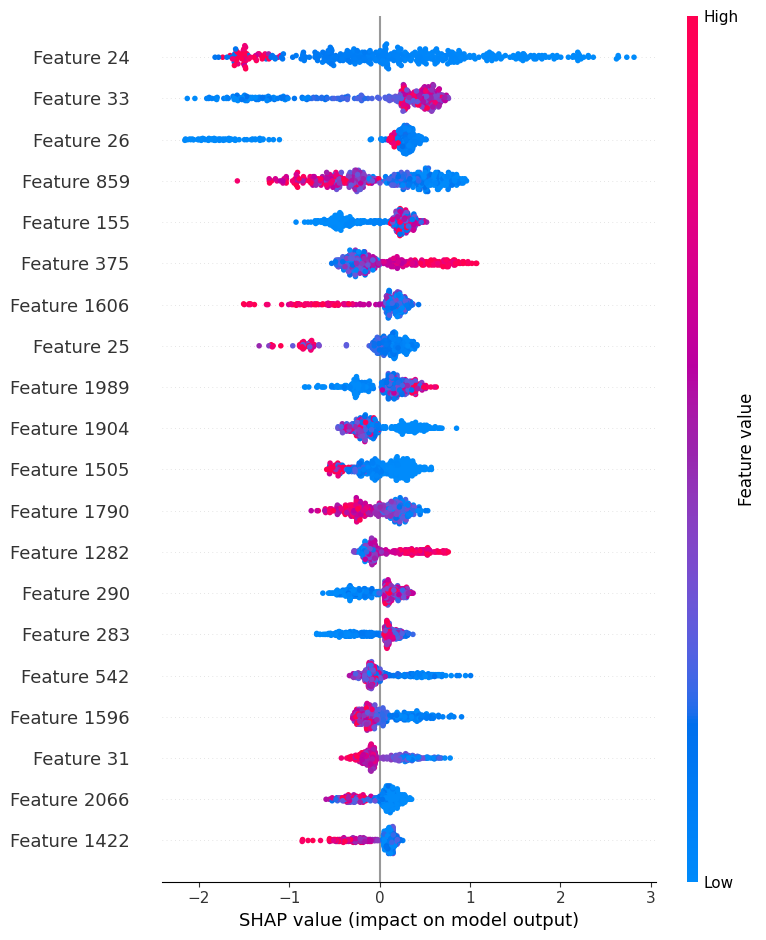

In [ ]:
!pip install shap
import shap
#understand the importance of different features in the XGBoost model's predictions.


# Initialize SHAP Explainer
explainer = shap.Explainer(xgb_model, X_train)
shap_values = explainer(X_test)

# Summary Plot
shap.summary_plot(shap_values, X_test)


Hyperparameter Tuning

Tune SVM with GridSearchCV


C	Controls margin width (higher = less margin, but better classification).
kernel	Type of decision boundary (e.g., linear, rbf).
gamma	Controls how far influence of a point reaches.

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameters
svm_params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': [0.01, 0.1, 1]
}

# Grid Search
svm_grid = GridSearchCV(SVC(), svm_params, cv=5, scoring='accuracy', n_jobs=-1)
svm_grid.fit(X_train, y_train)

# Best Parameters
print("Best SVM Parameters:", svm_grid.best_params_)
print("Best SVM Accuracy:", svm_grid.best_score_)


Best SVM Parameters: {'C': 0.1, 'gamma': 0.01, 'kernel': 'linear'}
Best SVM Accuracy: 0.8767212996128659


Tune XGBoost with RandomizedSearchCV

n_estimators	Number of decision trees.
max_depth	Depth of each tree (higher = more complex model).
learning_rate	Controls how much model adjusts in each step.
subsample	Fraction of training data used per tree.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

# Define hyperparameters
xgb_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0]
}

# Random Search
xgb_grid = RandomizedSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
                              xgb_params, cv=5, scoring='accuracy', n_jobs=-1, n_iter=10)
xgb_grid.fit(X_train, y_train)

# Best Parameters
print("Best XGBoost Parameters:", xgb_grid.best_params_)
print("Best XGBoost Accuracy:", xgb_grid.best_score_)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:46:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best XGBoost Parameters: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.2}
Best XGBoost Accuracy: 0.9164206375049748


Testing

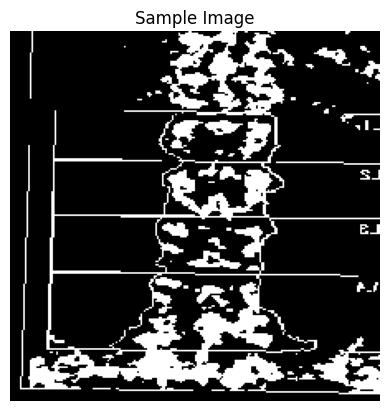

In [ ]:
# Path to sample image in Google Drive
sample_image_path = "/content/normal16.png"  # Update this

# Load Image
sample_img = load_img(sample_image_path, target_size=IMG_SIZE, color_mode="rgb")
sample_img = img_to_array(sample_img) / 255.0  # Normalize

# Display Image
plt.imshow(sample_img)
plt.axis("off")
plt.title("Sample Image")
plt.show()



In [ ]:
print("Final Sample Features Shape:", sample_features.shape)


Final Sample Features Shape: (1, 2082)


In [ ]:
print("Sample Gabor Shape:", sample_gabor.shape[0])
print("Sample LBP Shape:", sample_lbp.shape[0])
print("Sample ResNet50 Shape:", sample_resnet.shape[0])


Sample Gabor Shape: 24
Sample LBP Shape: 10
Sample ResNet50 Shape: 2048


In [ ]:
probs = xgb_model.predict_proba(sample_features_scaled)
print("Prediction Probabilities:", probs)


Prediction Probabilities: [[0.92661023 0.0733898 ]]


In [ ]:
# Ensure correct feature shapes
sample_gabor = sample_gabor[:24]  # Ensure it has 24 features
sample_lbp = sample_lbp[:10]  # Ensure it has 10 features
sample_resnet = sample_resnet[:2048]  # Ensure it has 2048 features

# Combine features correctly
sample_features = np.hstack([sample_gabor, sample_lbp, sample_resnet])

# Ensure same shape before scaling
sample_features = sample_features.reshape(1, -1)

# Scale features
sample_features_scaled = scaler.transform(sample_features)

# Predict with XGBoost
prediction = xgb_model.predict(sample_features_scaled)
predicted_label = encoder.inverse_transform(prediction)

print("Predicted Osteoporosis Risk:", predicted_label[0])


Predicted Osteoporosis Risk: normal



.













.




.

In [ ]:
threshold = 0.2  # Adjust this to find the best threshold
predicted_label = "Osteoporosis" if probs[0][1] > threshold else "Normal"

print("Updated Prediction:", predicted_label)


Updated Prediction: Normal


In [ ]:
from sklearn.preprocessing import StandardScaler

# Refit Scaler on the Full Training Features
scaler = StandardScaler()
scaler.fit(final_features)  # final_features contains Gabor, LBP, ResNet50 features

# Now, scale the sample image
sample_features_scaled = scaler.transform(sample_features.reshape(1, -1))


In [ ]:
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight

# Compute class weights
sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)

# Train XGBoost with class weights
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train, sample_weight=sample_weights)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:06:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)